## Introduction:

This Notebook is the second version, as per the last visualization analysis we get the idea about the data. This notebook present the machine learning training pipeline for given dataset. The are 21,367 labeled images with 5 different classes. 


I will first  do some image augmentation and transfer learning for training. The model will be Efficient_Net (scalled CNN Network). Read this blog post for more information about the Model Research Paper itself. [Blog]()


Here, I will use the recent published Efficient Net (scalled CNN network) for training from Tensorflow Library. The data is stored in google drive and I am using a colab environement.



In [2]:
# import libraries
import os
import re, gc              # regular expression and garbage collector.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, accuracy_score
import cv2

# tensorflow and relevant dependencies
import tensorflow as tf
import tensorflow.keras.backend as K      # for tensor manipulation library 
!pip install -q efficientnet
from efficientnet.tfkeras import *

     |████████████████████████████████| 51kB 2.4MB/s 


## Configuration
* I will use the free TPU provided by google colab for training the data. For that need to configure TPU and because TPU are closed enough to GCS bracket it gives faster speed. The reality of Kaggle dataset is as follow:
* kaggle will copy the dataset to GCS (Google Cloud Storage) when you ask for GCS access to it through KaggleDatasets(). ... The data will be copied to a cache bucket in the same location as the TPU you have been allocated.


In [3]:
Unit = 'TPU'

if Unit == "TPU":
  print('Connecting to TPU...')
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
  except:
    print('Could not connect to TPU, local machine is ready to handle load')
    tpu = None

  if tpu:
    try:
      print("Initializting TPU ...")
      tf.config.experimental_connect_to_cluster(tpu)
      tf.tpu.experimental.initialize_tpu_system(tpu)
      strategy = tf.distribute.experimental.TPUStrategy(tpu)
      print('TPU initialized')
    except:
      print('Failed to initialize TPU')
    else:
      Unit = 'GPU'

if Unit != 'TPU':
  print('Using default strategy for CPU and single GPU')
  strategy = tf.distribute.get_strategy()

if Unit == 'GPU':
  print("Num GPU Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print('Total Number of Replicas: ',REPLICAS)

Connecting to TPU...
Running on TPU  grpc://10.121.153.130:8470
Initializting TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.121.153.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.121.153.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
Using default strategy for CPU and single GPU
Num GPU Available:  0
Total Number of Replicas:  1


In [4]:
dir = '/content/drive/MyDrive/Data/Cassava_Leaf_Disease/'
train_dir = '/content/drive/MyDrive/Data/Cassava_Leaf_Disease/train_images/'
test_dir = '/content/drive/MyDrive/Data/Cassava_Leaf_Disease/test_images/'

In [5]:
# define reproducibility
seed = 17
'''
# image
train_df = pd.read_csv(dir + 'train.csv')
images, labels = train_df['image_id'].tolist(), train_df['label'].tolist()
image = cv2.imread(train_dir+images[0])
print(image.size)
print(image.shape)

image_size = [image.shape[0], image.shape[1]]
print(image_size)
'''
Image_size = [512,512]

batch_size = 16 * REPLICAS
aug_batch_size = batch_size *2 
FOLDS = 5 
first_fold = False
verbose = 1


In [6]:
#Configuration environment
import os
!pip install --upgrade kaggle

# Kaggle API (generate new key from account setttings, first expired old one)
os.environ['KAGGLE_USERNAME'] = "dave117" # username from the json file
os.environ['KAGGLE_KEY'] = "e71a3dc858b5cf0211105037ae969267" # key from the json file (generate new key everytime from account setting)

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.10)


In [7]:
# Define GCP dataset path for working closely to TPU. (in reality: GCP to Google Colab TPU have more data transfer and processing speed.)
# NOTE: These path are generated from Kaggle Notebook as the Kaggle data directory not supported by Colab. 
GCS_PATH = 'gs://kds-70e61c73aa57de69d3dea04d48c1a5a4ca0ba63756183ec8c1deddc3'
GCS_PATH_ORG = 'gs://kds-4245ff11b7408e3c6a890f24aba2ec1f985a7a9e2f77fda0a9c6e620'
print(GCS_PATH, GCS_PATH_ORG)       #can use these in Colab notebook

gs://kds-70e61c73aa57de69d3dea04d48c1a5a4ca0ba63756183ec8c1deddc3 gs://kds-4245ff11b7408e3c6a890f24aba2ec1f985a7a9e2f77fda0a9c6e620


In [8]:
# genrating helper function for data reading. 

# image extraction
def decode_image(image_data):                                                  
  image = tf.image.decode_jpeg(image_data, channels = 3)                        # decode jpeg image to uint8 tensor 
  print('Decoded Image Data: ', image_data.shape)   
  image = tf.cast(image, tf.float32) / 255.0                                    # cast tensor in new type
  print('Cast Image to float32/255: ', image.shape)
  # tpu need to image size for operation
  image = tf.reshape(image, [*Image_size, 3])                                   # reshape data ()
  print('change the data shape for format: ', image.shape)
  return image

# read labeled data
def read_labeled_data(image):
  labeled_data_format = {
      "image" : tf.io.FixedLenFeature([], tf.string),                           # configuration for parsing a fixed length input feature.
      "target": tf.io.FixedLenFeature([],tf.int64),                             
  }
  data = tf.io.parse_single_example(image, labeled_data_format)                 # parse photo to defined format (which we defined earlier) - shape will be same as input, if there is not batch_size
  image  = decode_image(data['image'])
  label = tf.cast(data['target'], tf.int32)

  # return a dataset of (image, label) pairs
  return image, label

# read unlabeled data
def read_unlabeled_data(image, return_image_name):
  unlabeled_data_format = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "id": tf.io.FixedLenFeature([],tf.string),
  }
  data = tf.io.parse_single_example(image, unlabeled_data_format)
  image = decode_image(data['image'])
  id_num = data['id']                       # no label
  return image, id_num if return_image_name else 0

# total data count
def count_data_items(filenames):
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames] 
  return np.sum(n)

In [9]:
# data augmentation
def data_augment(image, label, flip_only = True):

  if flip_only:
    imgs = tf.image.random_flip_left_right(image)

  else:
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_hue(img, 0.01)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    imgs = tf.image.random_brightness(img, 0.1)

  return imgs, label


# augmented dataset return
def get_dataset(files, course_drop = False, grid_mask = False, mat_aug= False,
                cutmixup = False, one_hot = False,all_aug = False, shuffle= False, 
                repeat= False, labeled = True, return_image_names= True, 
                batch_size= batch_size, dim = Image_size[0]):
  ds = tf.data.TFRecordDataset(files, num_parallel_reads=None)

  if repeat:
    ds = ds.repeat()

  if shuffle:
    ds = ds.shuffle(2048)
    opt = tf.data.Options()
    opt.experimental_deterministic = False
    ds = ds.with_options(opt)

  if labeled:
    ds = ds.map(read_labeled_data, num_parallel_calls= AUTO)
  else:
    ds = ds.map(lambda data: read_unlabeled_data(data, return_image_names), num_parallel_calls= AUTO)

  if course_drop:
    ds = ds.map(data_augment, num_parallel_calls= AUTO)
    ds = ds.map(lambda img, label: (dropout(img), label), num_parallel_calls= AUTO)

  if grid_mask:
    ds = ds.map(data_augment, num_parallel_calls= AUTO)
    ds = ds.map(apply_grid_mask, num_parallel_calls= AUTO)

  if mat_aug:
    ds = ds.map(data_augment, num_parallel_calls= AUTO)
    ds = ds.map(transform, num_parallel_calls= AUTO)
  
  if all_aug:
    ds = ds.map(data_augment, num_parallel_calls=AUTO)
    ds = ds.map(apply_all_aug, num_parallel_calls=AUTO)

  if cutmixup:
    ds = ds.batch(aug_batch_size)
    ds = ds.map(cut_and_mix, num_parallel_calls= AUTO)

    ds = ds.unbatch()
    ds = ds.shuffle(2048)

  if one_hot:
    ds = ds.amp(onehot, num_parallel_calls= AUTO)

  ds = ds.batch(batch_size)
  ds = ds.prefetch(AUTO)
  return ds


In [10]:
training_filenames =  tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
test_filenames = tf.io.gfile.glob(GCS_PATH_ORG + '/test_tfrecords/ld_test*.tfrec')

NUM_TRAINING_IMAGES = int( count_data_items(training_filenames) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(training_filenames) * 1/FOLDS )
NUM_TEST_IMAGES = count_data_items(test_filenames)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // batch_size

print(f'Dataset: {NUM_TRAINING_IMAGES} training images, {NUM_VALIDATION_IMAGES} validation images, {NUM_TEST_IMAGES} (unlabeled) test images')

Dataset: 17116 training images, 4279 validation images, 1 (unlabeled) test images


## Visualization

Look at data after data extraction and augmentation.

In [11]:
np.set_printoptions(threshold = 15, linewidth = 80)                             # define how the print option will return the result. (threshold = num of return o/p, line width = num of characters print per line)

classes = ['0','1','2','3','4']

def batch_to_numpy_images_and_labels(data):                                     # convert images and labels to numpy format.
  images, labels = data
  numpy_images = images.numpy()
  numpy_labels = labels.numpy()
  if numpy_images.dtype == object:                                              # define None foe empty lables
    numpy_labels = [None for _ in enumerate(numpy_images)]
  return numpy_images, numpy_labels

def title_from_labels_and_target(label, correct_label):                       
  if correct_label is None:
    return CLASSES[label], True
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
                                
def display_one_image(image, title, subplot, red = False, titlesize = 16):
  plt.subplot(*subplot)
  plt.axis('off')
  plt.imshow(image)
  if len(title) >0:
    plt.title(title, fontsize= int(titlesize) if not red else int(titlesize/1,2), color = 'red' if red else 'black', fontdict={'verticalalignment':'center'}, pad = int(titlesize/1.5))
  return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
    
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else classes[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3
        subplot = display_one_image(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [12]:
# final dataset
training_dataset = get_dataset(training_filenames, labeled = True, course_drop = False, all_aug= False, grid_mask= False, mat_aug=False, cutmixup=False, shuffle=True, repeat=True)
training_dataset = training_dataset.unbatch().batch(20)                         # from previous batch to unbatch and rebatch of 20. (batch size conversion)
train_batch = iter(training_dataset)

Decoded Image Data:  ()
Cast Image to float32/255:  (None, None, 3)
change the data shape for format:  (512, 512, 3)


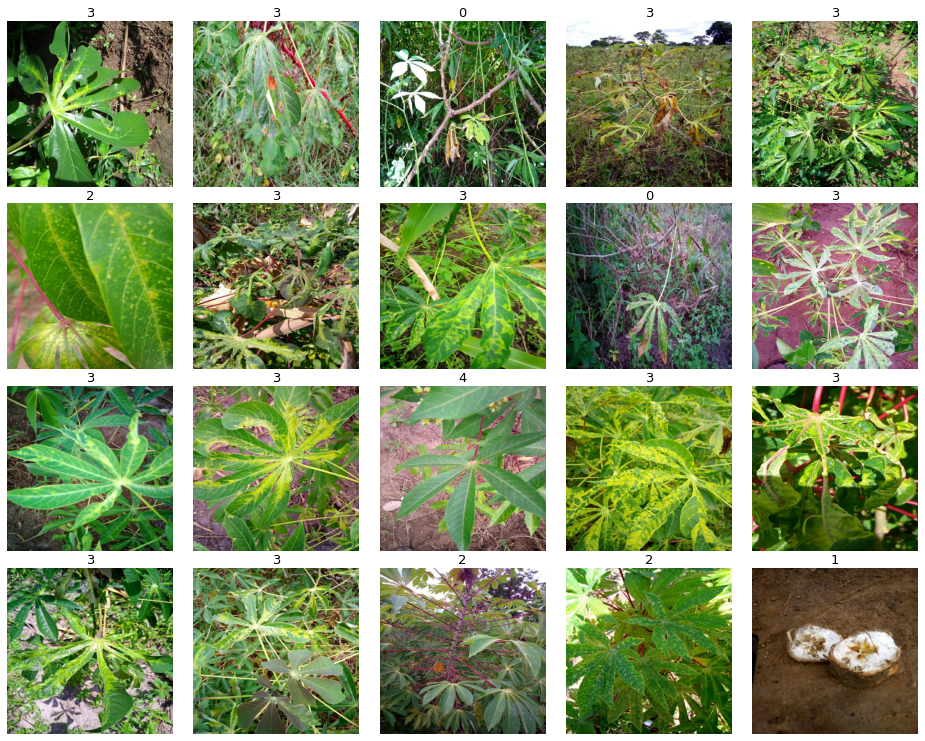

In [13]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(train_batch))

## 3. Augmentations

#### Rotation, Shift, Zoom and Shear

In [14]:
def get_matrix(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
  rotation = math.pi * rotation / 180.00
  shear = math.pi * shear / 180.00

  c1 = tf.math.cos(rotation)
  s1 = tf.math.sin(rotation)
  one = tf.constant([1], dtype = 'float32')
  zero = tf.constant([0], dtype= 'float32')
  rotation_matrix = tf.reshape(tf.concat([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=0),[3,3])

  c2 = tf.math.cos(shear)
  s2 = tf.math.sin(shear)
  shear_matrix = tf.reshape( tf.concat([one,s2, zero, -s1,c1,zero, zero, zero, one], axis = 0),[3,3])

  zoom_matrix = tf.reshape( tf.concat([one/height_zoom, zero, zero, zero, one/width_zoom, zero, zero, zero, one], axis=0),[3,3])

  shift_matrix = tf.reshape(tf.concat([one, zero, height_shift, zero, one, width_shift, zero, zero, one], axis = 0), [3,3])

  return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image, label, dim = Image_size[0]):
  xdim = dim % 2

  rot = 15. * tf.random.normal([1],dtype='float32')                             # tf.random.normal(shape, mean=0, stddev=1, dtype, seed=None, name=None)
  shr = 5. * tf.random.normal([1], dtype='float32')
  h_zoom = 1.0 + tf.random.normal([1], dtype= 'float32')/10.
  w_zoom = 1.0 + tf.random.normal([1], dtype= 'float32')/10.
  h_shift = 16. * tf.random.normal([1], dtype = 'float32')
  w_shift = 16. * tf.random.normal([1],dtype='float32')

  m = get_matrix(rot,shr,h_zoom, w_zoom, h_shift,w_shift)

  x = tf.repeat(tf.range(dim//2, -dim//2, -1), dim)
  y = tf.tile( tf.range(-dim//2, dim//2), [dim])
  z = tf.ones([dim*dim], dtype ='int32')
  idx = tf.stack([x,y,z])

  idx2 = K.dot(m,tf.cast(idx, dtype= 'float32'))
  idx2 = K.cast(idx2, dtype='int32')
  idx2 = K.clip(idx2, -dim//2 + xdim +1, dim//2)

  idx3 = tf.stack([dim//2-idx2[0,], dim//2-1+idx2[1,]])
  d = tf.gather_nd(image, tf.transpose(idx3))
  return tf.reshape(d, [dim,dim,3]),label



Decoded Image Data:  ()
Cast Image to float32/255:  (None, None, 3)
change the data shape for format:  (512, 512, 3)


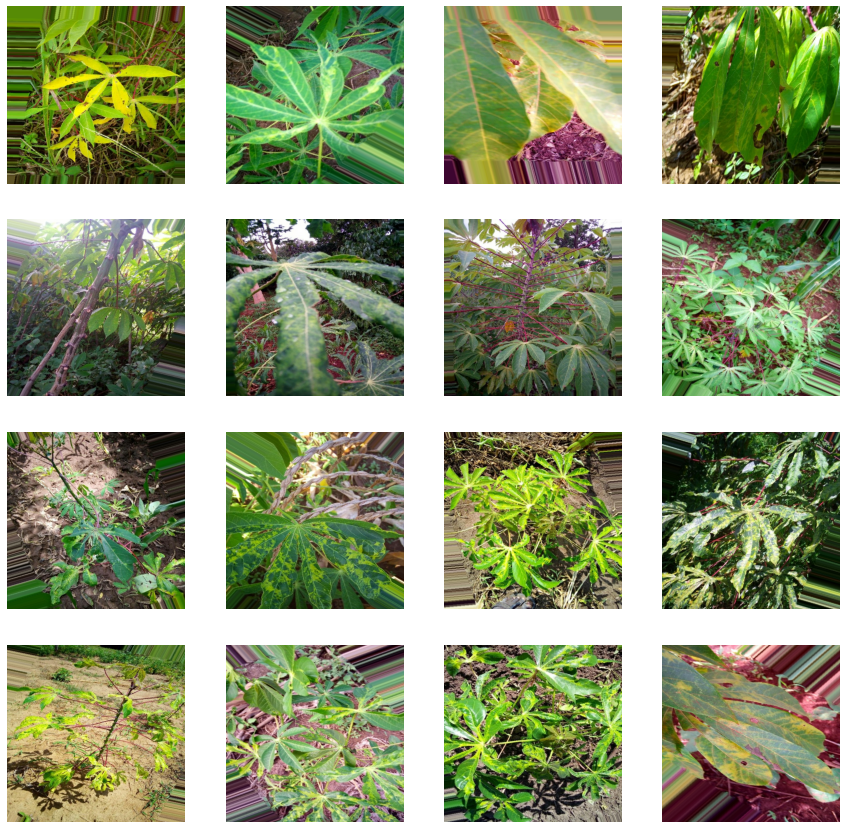

In [15]:
row = 4; col = 4;
row = min(row, batch_size//col)
all_elements  = get_dataset(training_filenames, labeled= True, mat_aug= True, course_drop = False, cutmixup = False, shuffle= True, repeat= True)
all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
  plt.figure(figsize=(15,15))
  for j in range(16):
    plt.subplot(row,col,j+1)
    plt.axis('off')
    plt.imshow(img[j,])
  plt.show()
  break

### Coarse Dropout



In [16]:
 def dropout(image, dim = Image_size[0], probability = 1, CT = 8, SZ= 0.2):
   prob = tf.cast(tf.random.uniform([],0,1)<probability, tf.int32)
   if (prob==0) | (CT==0) | (SZ==0): return image

   for k in range(CT):
     x = tf.cast(tf.random.uniform([],0,dim), tf.int32)
     y = tf.cast(tf.random.uniform([],0,dim), tf.int32)
     width = tf.cast(SZ * dim, tf.int32) * prob
     ya = tf.math.maximum(0, y-width//2)
     yb = tf.math.minimum(dim, y+width//2)
     xa = tf.math.maximum(0,x-width//2)
     xb = tf.math.minimum(dim,x+width//2)

     one = image[ya:yb, 0:xa, :]
     two = tf.zeros([yb-ya, xb-xa, 3])
     three = image[ya:yb, xb:dim,:]
     middle = tf.concat([one, two, three], axis=1)
     image = tf.concat([image[0:ya,:,:],middle, image[yb:dim,:,:]],axis=0)
   image = tf.reshape(image, [dim,dim,3])
   return image

Decoded Image Data:  ()
Cast Image to float32/255:  (None, None, 3)
change the data shape for format:  (512, 512, 3)


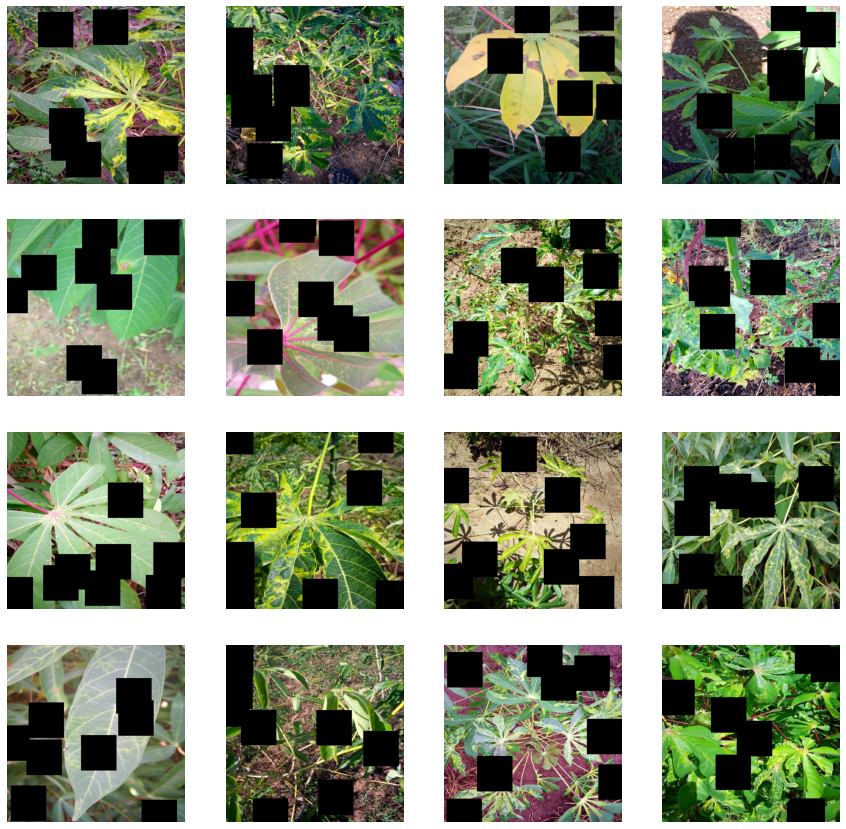

In [17]:
row = 4; col =4;
row = min(row,batch_size//col)
all_elements = get_dataset(training_filenames, labeled=True, mat_aug=False, cutmixup=False, grid_mask=False, course_drop=True, shuffle=True, repeat=True)

all_elements = all_elements.unbatch().batch(20)

for (img,lablel) in all_elements:
  plt.figure(figsize=(15,15))
  for j in range(16):
    plt.subplot(row,col,j+1)
    plt.axis('off')
    plt.imshow(img[j,])
  plt.show()
  break

### Grid Mask

In [18]:
Aug_Parameters = {
    'd1' : 100,
    'd2' : 160,
    'rotate' : 45,
    'ratio' : 0.4
}

In [19]:
def transform2(image, inv_mat, image_shape):
  h, w, c = image_shape
  cx, cy = w//2, h//2

  new_xs = tf.repeat(tf.range(-cx,cx,1), h)
  new_ys = tf.tile(tf.range(-cy,cy,1), [w])
  new_zs = tf.ones([h*w], dtype= tf.int32)

  old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
  old_coords_x, old_coords_y = tf.round(old_coords[0,:] + w//2), tf.round(old_coords[1,:]+ h//2)

  clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x> w-1)
  clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y> h-1)
  clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

  old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
  old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
  new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
  new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

  old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
  new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
  rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
  rotated_image_channel = list()
  for i in range(c):
    vals = rotated_image_values[:,i]
    sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h,w])
    rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value =0,validate_indices=False))

  return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):

  def get_rotation_matrix_inv(angle):
    angle = math.pi * angle/ 180 
    cos_val = tf.math.cos(angle)
    sin_val = tf.math.sin(angle)
    one = tf.constant([1], tf.float32)
    zero = tf.constant([0], tf.float32)

    rot_mat_inv = tf.concat([cos_val, sin_val, zero, -sin_val, cos_val, zero, zero, zero, one], axis = 0)
    rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])
    return rot_mat_inv

  angle = float(angle) * tf.random.normal([1], dtype = 'float32')
  rot_mat_inv = get_rotation_matrix_inv(angle)
  return transform2(image, rot_mat_inv, image_shape)

def grid_mask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):
  h,w = image_height, image_width
  hh = int(np.ceil(np.sqrt(h*h + w*w)))
  hh += 1 if hh%2 ==1 else hh 
  d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype =tf.int32)
  l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

  st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
  st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

  y_ranges = tf.range(-1*d + st_h, -1* d + st_h + 1)
  x_ranges = tf.range(-1*d + st_w, -1* d + st_w + 1)

  for i in range(0,hh//d+1):
    s1 = i* d +st_h
    s2 = i* d +st_w
    y_ranges = tf.concat([y_ranges, tf.range(s1,s1+1)], axis=0)
    x_ranges = tf.concat([x_ranges, tf.range(s2,s2+1)], axis=0)

  x_clip_mask = tf.logical_or(x_ranges <0, x_ranges> hh-1)
  y_clip_mask = tf.logical_or(y_ranges <0, y_ranges >hh-1)
  clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

  x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
  y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

  hh_ranges = tf.tile(tf.range(0,hh),[tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)),tf.int32)])

  x_ranges = tf.repeat(x_ranges, hh)
  y_ranges = tf.repeat(y_ranges, hh)

  y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
  x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

  y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64), tf.zeros_like(y_ranges), [hh,hh])
  y_mask = tf.sparse.to_dense(y_mask_sparse, 1 ,False)

  x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh,hh])
  x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

  mask = tf.expand_dims(tf.clip_by_value(x_mask + y_mask, 0, 1), axis = -1)

  mask = random_rotate(mask, rotate_angle, [hh,hh,1])
  mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

  return mask

def apply_grid_mask(image, label):
    mask = grid_mask(Image_size[0],
                    Image_size[1],
                    Aug_Parameters['d1'],
                    Aug_Parameters['d2'],
                    Aug_Parameters['rotate'],
                    Aug_Parameters['ratio'])
    
    if Image_size[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)

    return tf.cast(image * tf.cast(mask, tf.float32), tf.float32), label

Decoded Image Data:  ()
Cast Image to float32/255:  (None, None, 3)
change the data shape for format:  (512, 512, 3)


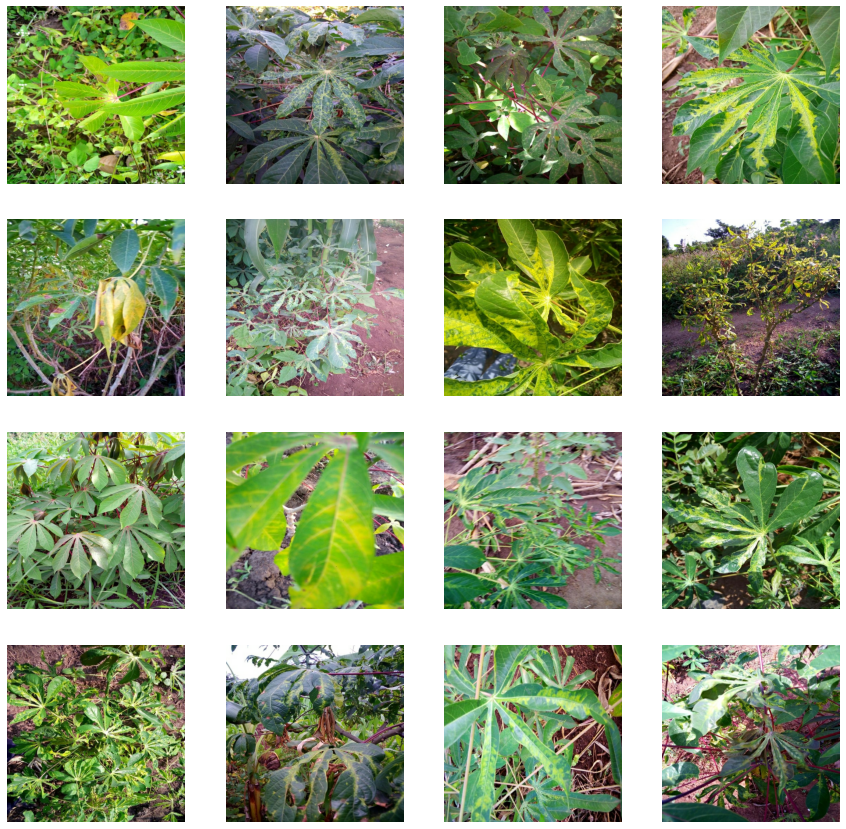

In [20]:
# display
row = 4; col = 4;
row = min(row, batch_size//col)
all_elements = get_dataset(training_filenames, labeled= True, grid_mask= True, mat_aug = False, cutmixup= False, course_drop=False, shuffle=True, repeat=True)
all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
  plt.figure(figsize=(15,15))
  for j in range(16):
    plt.subplot(row, col, j+1)
    plt.axis('off')
    plt.imshow(img[j,])
  plt.show()
  break

## All the Above

In [21]:
def apply_all_aug(img, label,no_grid=False):
  if tf.random.uniform([],0,1) > .5:
    if tf.random.uniform([],0,1) >.5:
      img, label = transform(img, label)
    else:
      img = dropout(img, probability=1)

  else:
    if not no_grid:
      if tf.random.uniform([],0,1)> .5:
        img, label = apply_grid_mask(img,label)
      else:
        img, label = img, label
  return img,label

Decoded Image Data:  ()
Cast Image to float32/255:  (None, None, 3)
change the data shape for format:  (512, 512, 3)


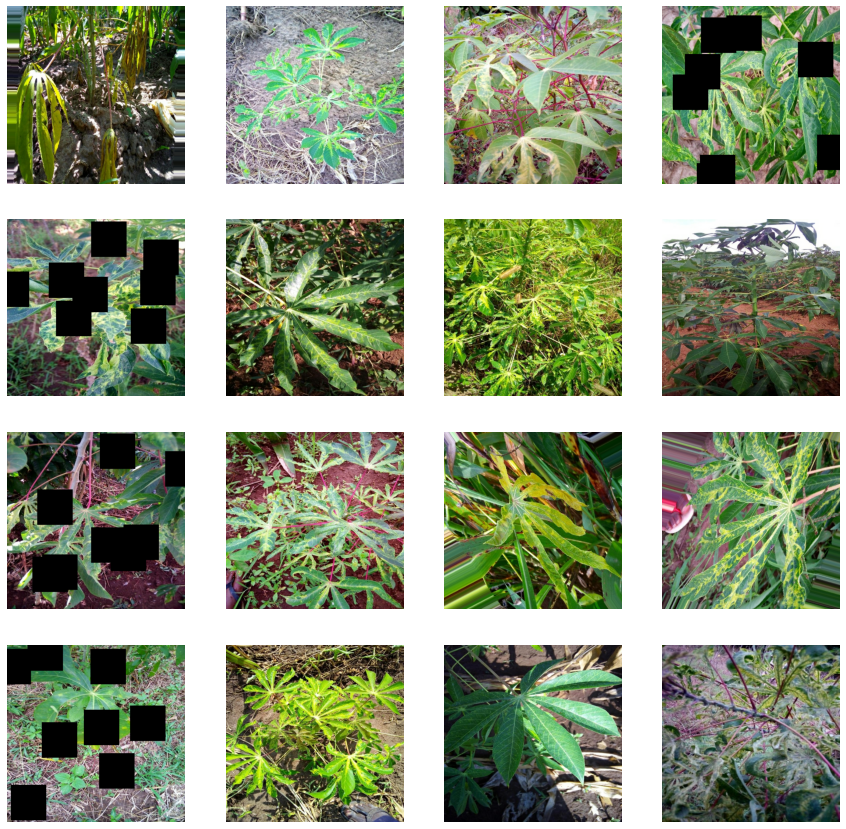

In [22]:
# display
row = 4; col = 4;
row = min(row, batch_size//col)
all_elements = get_dataset(training_filenames, labeled= True, grid_mask= False, all_aug=True,  mat_aug = False, cutmixup= False, course_drop=False, shuffle=True, repeat=True)
all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
  plt.figure(figsize=(15,15))
  for j in range(16):
    plt.subplot(row, col, j+1)
    plt.axis('off')
    plt.imshow(img[j,])
  plt.show()
  break

## Mix Up
Now, the augmentations we did above are great, but we are still adding noise to the images which is also leading to information loss. Luckily, we can do better with mixup. Essentially, all mixup does is randomly converts images to convex combinations of pairs of images and their labels.

In [32]:
# need to one hot encode images so we can blend their labels like above
def onehot(image, label):
  Classes = len(classes)
  return image, tf.one_hot(label, Classes)

def mixup(image, label, probability=1.0, dim = Image_size[0]):
  Classes = len(classes)

  imgs = [], labs = []
  for j in range(aug_batch_size):
    P = tf.cast(tf.random.uniform([],0,1) <= probability, tf.float32)
    k = tf.cast(tf.random.uniform([],0,aug_batch_size),tf.int32)
    a = tf.random.uniform([],0,1)*P 

    img1 = image[j,]
    img2 = image[k,]
    imgs.append((1-a)*img1 + a*img2)

    if len(label.shape) == 1:
      lab1 = tf.one_hot(label[j],Classes)
      lab2 = tf.one_hot(label[k],Classes)
    else:
      lab1 = label[j,]
      lab2 = label[k,]
    labs.append((1-a)*lab1 + a*lab2)

  image2 = tf.reshape(tf.stack(imgs), (aug_batch_size, dim, dim, 3))
  label2 = tf.reshape(tf.stack(labs), (aug_batch_size, Classes))
  return image2, label2

## CutMix
CutMix is essentially the same as mixup except the images are not blended together, rather a random sized block of one image is superimposed on another image.


In [33]:
def cutmix(image, label, probability=1.0, dim = Image_size[0]):
  Classes = len(classes)

  imgs = [], labs = []
  for j in range(aug_batch_size):
    P = tf.cast(tf.random.uniform([],0,1) <= probability, tf.float32)
    k = tf.cast(tf.random.uniform([],0,aug_batch_size),tf.int32)

    x = tf.cast(tf.random.uniform([], 0, dim) , tf.int32)
    y = tf.cast(tf.random.uniform([], 0, dim) , tf.int32)
    b = tf.random.unifrom([],0,1)
    width = tf.cast(dim * tf.math.sqrt(1-b), tf.int32) * P 

    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(dim, y+width//2)
    xa = tf.math.maximum(0,x-width//2)
    xb = tf.mth.minimum(dim, x+width//2)

    one = image[j, ya:yb, 0:xa, :]
    two = image[k, ya:yb, xa:xb, :]
    three = image[j, ya:yb, xb:dim, :]
    middle = tf.concat([one, two,three],axis=1)
    img =tf.concat([image[j,0:ya,:,:], middle, image[j,yb:dim,:,:]], axis =0)
    imgs.append(img)

    a = tf.cast(width*width/dim/dim, tf.float32)
    if len(label.shape) == 1:
      lab1 = tf.one_hot(label[j], Classes)
      lab2 = tf.one_hot(label[k], Classes)
    else:
      lab1 = label[j,]
      lab2 = label[k,]
    labs.append((1-a)*lab1 + a*lab2)

  image2 = tf.reshape(tf.stack(imgs), (aug_batch_size,dim,dim,3))
  label2 = tf.reshape(tf.stack(labs),(aug_batch_size,Classes))
  return image2, label2



###MixUp + CutMix
It is hard to choose which is better, mixup or CutMix. Luckily, we don't actually have to choose because we can just apply both. We can apply CutMix SWITCH * CUTMIX_PROB of the time and mixup (1 - SWITCH) * MIXUP_PROB of the time. We will need to experiment a bit to see which convex combination delivers the best performance, but this is a good starting point: mixup 33% of the time, CutMix 33% of the time, and no augmentation 33% of the time




In [38]:
def cut_and_mix(image, label, dim = Image_size[0]):
  Classes = len(classes)

  switch = 1/2

  cutmix_prob = 2/3
  mixup_prob = 2/3

  image2, label2 = cutmix(image, label, cutmix_prob)
  image3, label3 = mixup(image, label, mixup_prob)
  imgs = []; labs = []
  
  for j in range(batch_size):
    P = tf.cast(tf.random.uniform([],0,1) <= switch, tf.float32)
    imgs.append(P*image2[j,]+(1-P)*image3[j,])
    labs.append(P*label2[j,]+(1-P)*label3[j,])
  
  image4 = tf.reshape(tf.stack(imgs), (batch_size, dim, dim, 3))
  label4 = tf.reshape(tf.stack(labs), (batch_size, Classes))
  return image4, label4

In [39]:
# display
row = 4; col = 4;
row = min(row, batch_size//col)
all_elements = get_dataset(training_filenames, labeled= True, grid_mask= False, all_aug=False, cutmixup= True, course_drop=False, shuffle=True, repeat=True)
all_elements = all_elements.unbatch().batch(20)

for (img,label) in all_elements:
  plt.figure(figsize=(15,15))
  for j in range(16):
    plt.subplot(row, col, j+1)
    plt.axis('off')
    plt.imshow(img[j,])
  plt.show()
  break

Decoded Image Data:  ()
Cast Image to float32/255:  (None, None, 3)
change the data shape for format:  (512, 512, 3)


ValueError: ignored